In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split , ConcatDataset
import torch.utils.data as Data
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold,  StratifiedKFold
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using %s device'%device)

class dataset (Data.Dataset):
    def __init__(self, label, data):
        le = LabelEncoder()
        self.label = torch.tensor(le.fit_transform(label), dtype = torch.long, device = device)
        self.data = torch.tensor(data, dtype = torch.float).unsqueeze(1).unsqueeze(1)
                    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        label = self.label[idx]
        data = self.data[idx]
        return data, label # CNN x.shape = [1,1,1971]


def split_dataset(df, split_ratio = 0.75, augment = False, n = 150 ):
    df_x = df.iloc[:,:-1]
    df_y = df.iloc[:,-1]
    
    alldataset = dataset(label=df_y, data=df_x.values)
    
    lengths = [int(len(alldataset)*split_ratio), len(alldataset) - int(len(alldataset)*split_ratio)]
    train_set, test_set = random_split(alldataset, lengths)
     
    # augment-> add train_set
    if augment:
        augset = fake_AD_dataset(200)
        train_set = torch.utils.data.ConcatDataset([train_set, augset])
        
    return train_set, test_set


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(4,4)

        self.gen = nn.Sequential(
            nn.Linear(68, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,1971),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.embed(labels).squeeze(1)
        x = torch.cat([z, c], 1)
        # print(x.shape)
        return self.gen(x)

def create_fake_AD_data(n):
    G = Generator().to(device)
    G.load_state_dict(torch.load('model/shape_GAN.pth'))
    G.eval()  # eval - batch size ignore
    fake_data_list = []
    label = torch.cuda.LongTensor([0])
    for i in range(n):
        z = torch.randn(1, 64).to(device)   # latent size = 64
        fake_data = G(z, label)
        fake_data_list.append(fake_data)
    output = torch.stack(fake_data_list)
    output = output.to(device)
    return output


class fake_AD_dataset(Data.Dataset):
    def __init__(self,n):
        # le = LabelEncoder()
        self.label =  torch.zeros(n, dtype=torch.long, device=device)
        self.data = create_fake_AD_data(n).unsqueeze(1).to(device)
                    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        label = self.label[idx].to(device)
        data = self.data[idx].to(device)
        return data, label


class CNN_1D(torch.nn.Module):
    def __init__(self, input_shape):
        super(CNN_1D, self).__init__()   # (N,C,H,W)
        self.Conv1d=nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(1,71), stride = (1, 1), padding = (0, 35)),
                     nn.ReLU())
        # Kernel = (H,W)
        
        self.Pooling=nn.Sequential(
            nn.MaxPool2d(kernel_size=(1,2), stride = (1,2)),
            nn.ReLU()) 
        
        self.input_shape = torch.randn(input_shape)
        
        fc_in_feature = self.Pooling(self.Conv1d(self.input_shape))
        fc_in_feature = fc_in_feature.view(fc_in_feature.size(0), -1)              #
        self.fc = nn.Sequential(nn.Linear(fc_in_feature.size(-1), 128).to(device),
                            nn.ReLU(),
                            nn.Linear(128,4).to(device),
                            nn.Softmax(dim=1))       
        # self.initialize_weights() #### 가중치 초기화 ...????????????????????????/
        
    def forward(self, x):  
        x = x.to(device)
        out = self.Conv1d(x)
        out = self.Pooling(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out) 
        return out
    
    def initialize_weights(self):
        # track all layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v


def k_fold_train(df, num_epochs, augment = False ):
    CNN = CNN_1D(input_shape=input_shape).to(device)     # CNN initialize
    optimizer = torch.optim.Adam(CNN.parameters(), lr=1e-4)
    results = {}
    torch.manual_seed(42)

    # Define the K-fold Cross Validator
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
    
    df_x = df.iloc[:,:-1]
    df_y = df.iloc[:,-1]
# K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(df_x.values, df_y.values)):  # test set포함..?

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        trainloader_ = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)
    
        if augment:
            augset = fake_AD_dataset(200)
            augloader = torch.utils.data.DataLoader(augset, batch_size = 8)
            trainloader = itr_merge(augloader, trainloader_)
        
        else:
            trainloader = trainloader_

        for epoch in range(0, num_epochs):
            print(f'Starting epoch {epoch+1}')
            current_loss = 0.0

            for i, (data, label) in enumerate(trainloader):

                data = data.to(device)
                label = label.to(device)

                optimizer.zero_grad()
                output = CNN(data)

                loss = loss_function(output, label)
                loss.backward()
                optimizer.step()

                current_loss += loss.item()
        print(f'Training process {fold}-fold has finished')
        print('Save model. starting test.')

        save_path = f'model/fold_{fold}.pth'
        torch.save(CNN.state_dict(), save_path)

        correct, total = 0,0
        with torch.no_grad():
            test_output = []
            test_label = []
            for i, (data, label) in enumerate(testloader):
                CNN.eval()

                data = data.to(device)
                label = label.to(device)

                output = CNN(data)

                loss= loss_function(output, label)

                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

                test_output.append(predicted.cpu().data.numpy())
                test_label.append(label.cpu().data.numpy())
            print('Accuracy for fold %d : %d %%' %(fold, 100.0 * correct/total))
            results[fold] = 100.0 * (correct/total)

        print(f'K-fold CV result for {k_folds} Folds')
        sum = 0.0
        for key, value in results.items():
            print(f'Fold {key} : {value} %')
            sum += value
        print(f'Average : {sum/len(results.items())} %')
        print('classification report')

        classification_report_ = classification_report(test_label, test_output, labels=[0,1, 2, 3])
        print(classification_report_)
        matrix = confusion_matrix(test_label, test_output)
        print(matrix)


def test_train(df, num_epochs, augment=False):
    num_feature = len(df.columns)-1
    input_shape = (1,1,1,num_feature)
    CNN = CNN_1D(input_shape=input_shape).to(device)   
    optimizer = torch.optim.Adam(CNN.parameters(), lr=1e-4)
    
    if augment == False :
        train_set, test_set = split_dataset(df, augment=False)
    else :
        train_set, test_set = split_dataset(df, augment=True)
    
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, drop_last=True)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=1, drop_last=True)
    
    train_epoch_loss = []
    test_epoch_loss = []    
    train_epoch_accuracy = []
    test_epoch_accuracy = []
    
    # train_epoch
    for epoch in range(num_epochs):
        # train 
        CNN.train()
        
        correct, current_loss = 0 , 0 # train loader loss for epoch loss
        total_num = 0 
        
        for X, y in trainloader : 
            X = X.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            output = CNN(X)
            loss = loss_function(output, y)
            loss.backward(retain_graph=True)
            optimizer.step()
            current_loss += (loss.item() / X.size(0))
            
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == y).sum().item()
            total_num += X.size(0)
            
        train_epoch_loss.append(current_loss)
        epoch_accuracy = ( correct/total_num)
        epoch_loss = current_loss
        
        epoch_accuracy = ( correct/total_num)
        train_epoch_accuracy.append(epoch_accuracy)
        
        if epoch % 50 == 0 :
            print(f'{epoch} epoch \ntrain loss  : { epoch_loss:.4f} | train accuracy  : {epoch_accuracy:.4f}')
        
        # test in each epoch
            with torch.no_grad():
                CNN.eval()

                # test_output, label save -> classification report
                test_output = []
                test_label = []

                correct, current_loss = 0, 0
                total_num = 0
                for X, y in testloader:
                    X = X.to(device)
                    y = y.to(device)

                    output = CNN(X)
                    _, predicted = torch.max(output.data, 1)
                    correct += (predicted == y).sum().item()

                    test_output.append(predicted.cpu().data.numpy())
                    test_label.append(y.cpu().data.numpy())
                    total_num += X.size(0)
                    
                    loss = loss_function(output, y)
                    current_loss += (loss.item() / X.size(0))
                
                epoch_accuracy = (correct / total_num)
                test_epoch_loss.append(current_loss)
                epoch_accuracy = (correct / total_num)
                
                epoch_accuracy = ( correct/total_num)
                test_epoch_accuracy.append(epoch_accuracy)
                
                print('test loss   : {:.4f} | test accuracy   : {:.4f}'.format(current_loss/total_num, correct/total_num))
                # classification_report_ = classification_report(test_label, test_output, labels=[0,1, 2, 3])
                matrix = confusion_matrix(test_label, test_output)
                
    plt.subplot(211).set_title("Train epoch loss")
    plt.plot(train_epoch_loss)
    plt.subplot(212).set_title('Test epoch loss')
    plt.plot(test_epoch_loss, 'r')
    plt.show() 
    
    ax = sns.heatmap(matrix, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix with\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

using cuda device


In [2]:
RF_df = pd.read_csv('selected_feature/RF.csv')   #8927
LR_df = pd.read_csv('selected_feature/LR.csv')   #1972
DT_df = pd.read_csv('selected_feature/DT.csv')   #102
SVM_df = pd.read_csv('selected_feature/SVM.csv') #151
LR_200 = pd.read_csv('selected_feature/LR200.csv') 
LR_400 = pd.read_csv('selected_feature/LR400.csv') 
LR_600 = pd.read_csv('selected_feature/LR600.csv') 
LR_800 = pd.read_csv('selected_feature/LR800.csv') 

In [3]:
SVM_df =pd.read_csv('selected_feature/SVM200.csv')

In [5]:
k_folds = 5
num_epochs = 1
loss_function = nn.CrossEntropyLoss()
batch_size = 8

In [6]:
dflist = [LR_df, LR_200, LR_400, LR_600, LR_800]
dfname = ['LR', 'LR_200', 'LR_400', 'LR_600', 'LR_800']

---------------------------
LR
---------------------------
0 epoch 
train loss  : 12.2723 | train accuracy  : 0.3007
test loss   : 1.4119 | test accuracy   : 0.3280
50 epoch 
train loss  : 6.5650 | train accuracy  : 0.9928
test loss   : 1.0221 | test accuracy   : 0.7151
100 epoch 
train loss  : 6.4147 | train accuracy  : 1.0000
test loss   : 0.8427 | test accuracy   : 0.9247
150 epoch 
train loss  : 6.4142 | train accuracy  : 1.0000
test loss   : 0.8302 | test accuracy   : 0.9355
200 epoch 
train loss  : 6.4142 | train accuracy  : 1.0000
test loss   : 0.8229 | test accuracy   : 0.9355
250 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.8181 | test accuracy   : 0.9301
300 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.8139 | test accuracy   : 0.9301
350 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.8001 | test accuracy   : 0.9624
400 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.8071 | test 

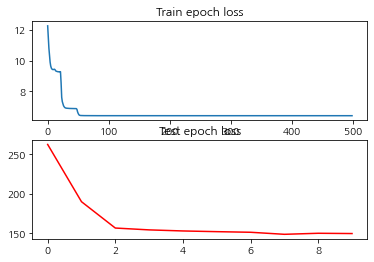

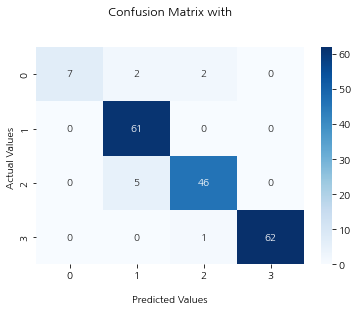

---------------------------
LR_200
---------------------------
0 epoch 
train loss  : 11.4438 | train accuracy  : 0.3696
test loss   : 1.3035 | test accuracy   : 0.4570
50 epoch 
train loss  : 6.8581 | train accuracy  : 0.9457
test loss   : 1.0132 | test accuracy   : 0.7366
100 epoch 
train loss  : 6.4297 | train accuracy  : 0.9982
test loss   : 0.9913 | test accuracy   : 0.7581
150 epoch 
train loss  : 6.4299 | train accuracy  : 0.9982
test loss   : 0.9841 | test accuracy   : 0.7581
200 epoch 
train loss  : 6.4298 | train accuracy  : 0.9982
test loss   : 0.9803 | test accuracy   : 0.7634
250 epoch 
train loss  : 6.4298 | train accuracy  : 0.9982
test loss   : 0.9841 | test accuracy   : 0.7688
300 epoch 
train loss  : 6.4298 | train accuracy  : 0.9982
test loss   : 0.9754 | test accuracy   : 0.7634
350 epoch 
train loss  : 6.4298 | train accuracy  : 0.9982
test loss   : 0.9773 | test accuracy   : 0.7634
400 epoch 
train loss  : 6.4298 | train accuracy  : 0.9982
test loss   : 0.9779 | t

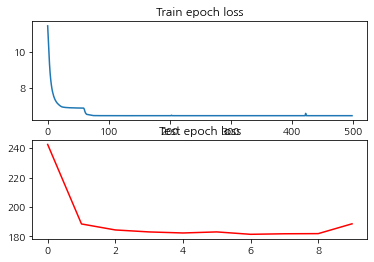

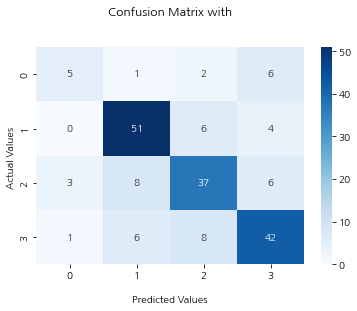

---------------------------
LR_400
---------------------------
0 epoch 
train loss  : 11.4233 | train accuracy  : 0.3551
test loss   : 1.3065 | test accuracy   : 0.3710
50 epoch 
train loss  : 6.8948 | train accuracy  : 0.9402
test loss   : 0.9658 | test accuracy   : 0.7957
100 epoch 
train loss  : 6.4162 | train accuracy  : 1.0000
test loss   : 0.9282 | test accuracy   : 0.8280
150 epoch 
train loss  : 6.4143 | train accuracy  : 1.0000
test loss   : 0.9167 | test accuracy   : 0.8441
200 epoch 
train loss  : 6.4142 | train accuracy  : 1.0000
test loss   : 0.9128 | test accuracy   : 0.8441
250 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.9109 | test accuracy   : 0.8280
300 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.9098 | test accuracy   : 0.8333
350 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.9096 | test accuracy   : 0.8280
400 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.9073 | t

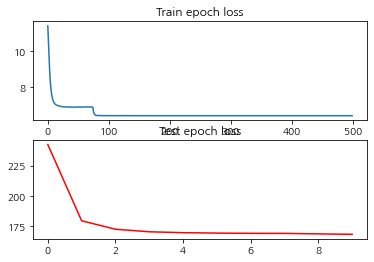

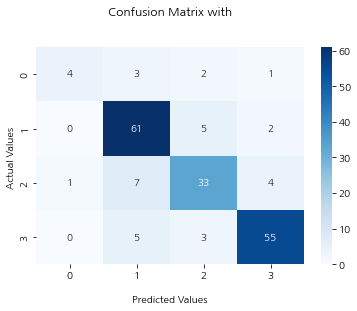

---------------------------
LR_600
---------------------------
0 epoch 
train loss  : 11.5248 | train accuracy  : 0.3551
test loss   : 1.3130 | test accuracy   : 0.4624
50 epoch 
train loss  : 6.7935 | train accuracy  : 0.9529
test loss   : 0.9565 | test accuracy   : 0.8118
100 epoch 
train loss  : 6.8063 | train accuracy  : 0.9529
test loss   : 1.0224 | test accuracy   : 0.7043
150 epoch 
train loss  : 6.8072 | train accuracy  : 0.9529
test loss   : 1.0183 | test accuracy   : 0.7151
200 epoch 
train loss  : 6.4154 | train accuracy  : 1.0000
test loss   : 0.9227 | test accuracy   : 0.8172
250 epoch 
train loss  : 6.4143 | train accuracy  : 1.0000
test loss   : 0.9123 | test accuracy   : 0.8226
300 epoch 
train loss  : 6.4142 | train accuracy  : 1.0000
test loss   : 0.9112 | test accuracy   : 0.8387
350 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.9120 | test accuracy   : 0.8387
400 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.9125 | t

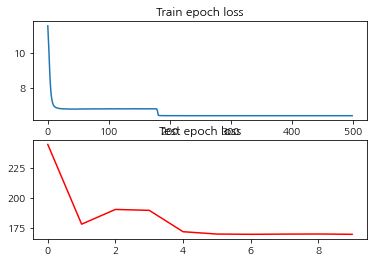

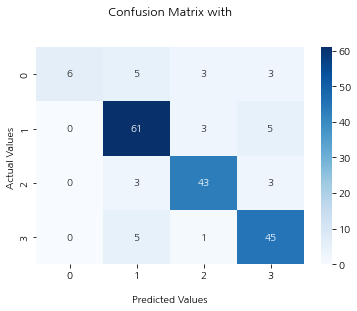

---------------------------
LR_800
---------------------------
0 epoch 
train loss  : 11.3966 | train accuracy  : 0.3678
test loss   : 1.3112 | test accuracy   : 0.3817
50 epoch 
train loss  : 6.8457 | train accuracy  : 0.9475
test loss   : 0.9558 | test accuracy   : 0.7903
100 epoch 
train loss  : 6.4147 | train accuracy  : 1.0000
test loss   : 0.8740 | test accuracy   : 0.8817
150 epoch 
train loss  : 6.4142 | train accuracy  : 1.0000
test loss   : 0.8714 | test accuracy   : 0.8817
200 epoch 
train loss  : 6.4142 | train accuracy  : 1.0000
test loss   : 0.8695 | test accuracy   : 0.8817
250 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.8678 | test accuracy   : 0.8817
300 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.8663 | test accuracy   : 0.8871
350 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.8613 | test accuracy   : 0.8871
400 epoch 
train loss  : 6.4141 | train accuracy  : 1.0000
test loss   : 0.8663 | t

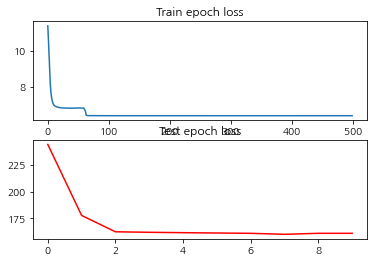

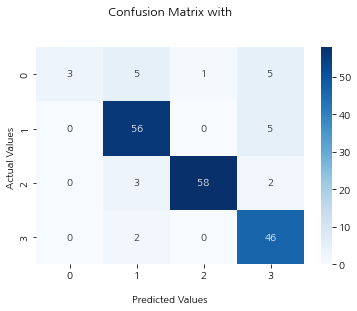

In [71]:
for i, df in enumerate(dflist):
    print("---------------------------")
    print(dfname[i])
    print("---------------------------")
    num_epochs = 500
    test_train(df, num_epochs)

In [62]:
GA = pd.read_csv('selected_feature/Genetic_selected.csv')

0 epoch 
train loss  : 11.5063 | train accuracy  : 0.3442
test loss   : 1.3299 | test accuracy   : 0.3656
50 epoch 
train loss  : 6.8683 | train accuracy  : 0.9457
test loss   : 1.2162 | test accuracy   : 0.5054
100 epoch 
train loss  : 6.5243 | train accuracy  : 0.9891
test loss   : 1.2111 | test accuracy   : 0.5269
150 epoch 
train loss  : 6.4927 | train accuracy  : 0.9909
test loss   : 1.2076 | test accuracy   : 0.5269
200 epoch 
train loss  : 6.4915 | train accuracy  : 0.9909
test loss   : 1.1902 | test accuracy   : 0.5538
250 epoch 
train loss  : 6.4924 | train accuracy  : 0.9909
test loss   : 1.1932 | test accuracy   : 0.5538


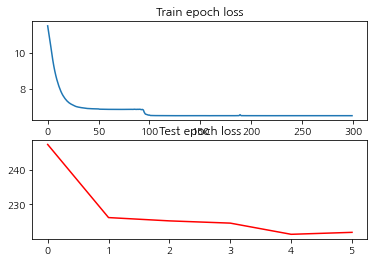

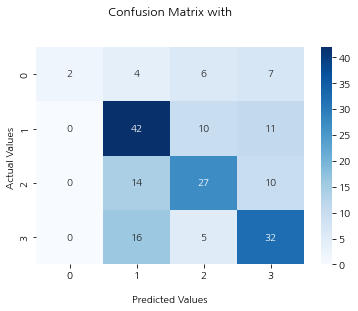

In [63]:
test_train(GA, 300)